In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predict pneumothorax vs no finding 

This project started with trying to recreate the ChestXNet project. Briefly explained, the ChestXNet group has developed an algorithm to classify pneumonia from other thoracic diseases in the ChestX-ray14 data set released by Wang et al. (2017). This data set contains of 112,120 frontal-view chest X-ray images, where each of them are labeled with up to 14 different diseases. You can read more about the CheXNet here: https://stanfordmlgroup.github.io/projects/chexnet/
<br>

Some of the issues I encountered along the way with this paper was that they have not described how they have balanced pneumonia in relation to all other diseases, how they have handled image of the same patient in the training and the validation sets, and how their test set looks like.
<br>

Therefore, it has been difficult for me to compare this project with theirs.
The purpose of recreating their project was to use a trained network on chest X ray14 data set to train another x-ray data set and look into the value of transfer learning.
To achieve a well trained network on chestX-ray 14 data set we have decided to look into another disease with more unique examples in the dataset compared with pneumonia.

In [2]:
import sys
sys.path.append("../../fastai/")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

In [4]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()

0

In [5]:
PATH = "/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/"  #MMIV
#PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/" #Home

In [6]:
sz=299
arch=dn121 #bytt denne til 121 igjen 
bs = 16

In [7]:
label_csv = f'{PATH}Data_Entry_2017.csv' 

In [8]:
df = pd.read_csv(label_csv)

In [9]:
df = df.drop(['Follow-up #','Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
              'OriginalImageWidth', 'OriginalHeight', 'OriginalImagePixelSpacingx', 'OriginalImagePixelSpacingy', 'Unnamed: 11'],axis=1)
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


## Top 10 diseases in the dataset


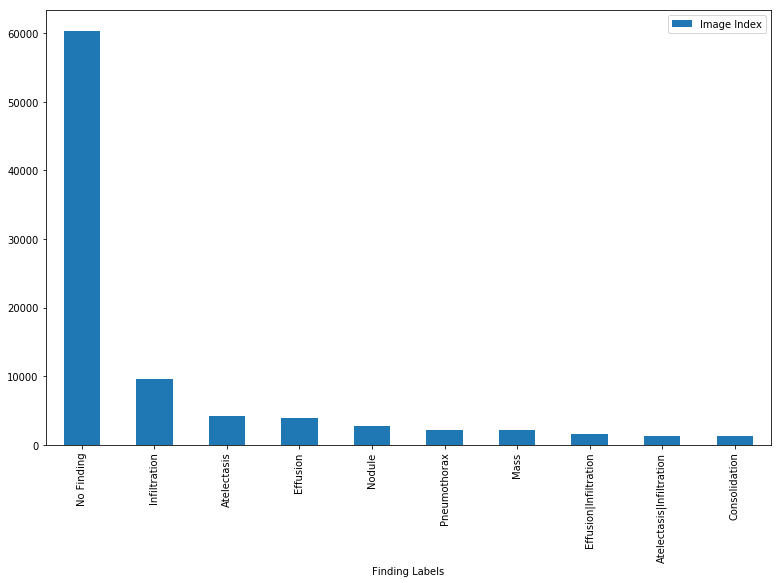

In [10]:
df_sorted = df.pivot_table(index='Finding Labels', aggfunc=len).sort_values('Image Index', ascending=False) 
df_sorted[0:10].plot(kind='bar',figsize=(13,8))

In [11]:
df_sorted.head(10)

,Image Index
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705
Pneumothorax,2194
Mass,2139
Effusion|Infiltration,1603
Atelectasis|Infiltration,1350


## Analyzing a specific disease
If this returns true, then skip to <i> view data</i> section

In [12]:
disease_name = 'Pneumothorax'
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv' 
exists = os.path.exists(cleaned_label_path)
if(False): 
    df = pd.read_csv(cleaned_label_path)
print('If exists equals true, then skip to view data section')
print('exists = ' + str(exists))

If exists equals true, then skip to view data section
exists = True


In [13]:
df_disease = df_sorted[df_sorted.index.str.contains(disease_name)]
disease_row = df_sorted.loc[disease_name]['Image Index']
total_apperance = sum(df_disease['Image Index'])
print(disease_name +': ' + str(disease_row) + '\n'+ 'Total apperance: ' + str(total_apperance))

Pneumothorax: 2194
Total apperance: 5302


In [14]:
df['searching_disease'] = df['Finding Labels'].str.contains(disease_name)
no_finding_idxs =  list(df.loc[df['Finding Labels'] == 'No Finding'].index)
searching_disease_idxs = list(df[df['searching_disease']].index) #all rows with disease_name 

In [15]:
arr = np.concatenate((no_finding_idxs, searching_disease_idxs))

In [16]:
df = df.iloc[df.index.get_indexer(arr)]

In [17]:
test_image_name_list = [line.rstrip('\n') for line in open(f'{PATH}test_list.txt')]
len(test_image_name_list)

25596

In [18]:
test_dic = {}
for img_name in test_image_name_list: 
    img_row = df.loc[df['Image Index'] == img_name]
    if not img_row.empty: 
        test_dic[img_name] = bool(img_row.searching_disease.values)
        pos = int(img_row.index.values)
        df = df.drop([pos])

In [19]:
len(test_dic)

12526

In [20]:
df = df.reset_index(drop=True)

### Ratio
Find the ratio to balance the data

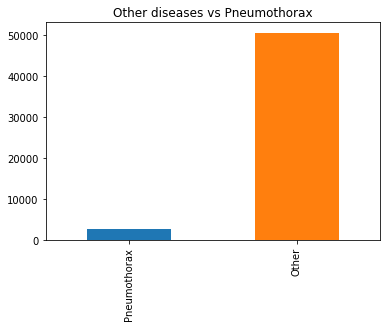

In [21]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [22]:
disease_count = df_sorted['Image Index'][0]
other_disease_count = df_sorted['Image Index'][1]
ratio = (other_disease_count// disease_count)-1
df = df.append([df[df.searching_disease]]*ratio, ignore_index=True) #df.searching_disease: array m true, false 
ratio

18

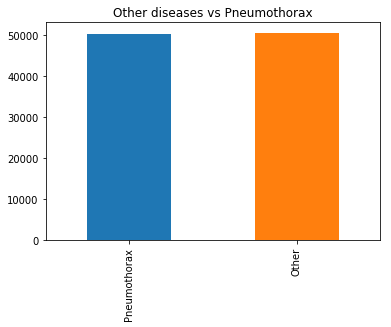

In [23]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [24]:
df = df.drop(['Finding Labels'], axis=1)
df.head() #00030196_001.png er true

,Image Index,searching_disease
0,00000002_000.png,False
1,00000005_000.png,False
2,00000005_001.png,False
3,00000005_002.png,False
4,00000005_003.png,False


In [25]:
df = shuffle(df)

In [26]:
cleaned_label_path = f'{PATH}cleaned_labels/{disease_name}.csv'
df.to_csv(cleaned_label_path, index=False)

In [27]:
with open(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv','w') as f:
    w = csv.writer(f)
    w.writerows(test_dic.items())

# View data 
The validation set we create with the training set may contain images of the same patient as there are several images of a patient. This may lead to better results on the validation set than on test set. 
Since we want a well trained network on chestX-ray 14 data set to look into the value of transfer learning, we have decided to use the test set as the validation set. 

In [28]:
# %load move_from_test_to_train.py


# In[2]:


import shutil
import os


# In[3]:


test_folder = '/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/test/'
train_folder = '/home/sathiesh/Deep_Learning_Kaliy/my_projects/chest-xrays/data/train'


# In[4]:


files = os.listdir(test_folder)

for f in files:
        shutil.move(test_folder+f, train_folder)



In [29]:
from move_files import * 

In [30]:
#move files from train to test
df_test = pd.read_csv(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv', header=None)
df_test.columns = ['Image Index', 'searching_disease']
move_to_test(PATH,df_test)

In [31]:
#for mer data på trening

n = len(list(open(cleaned_label_path)))
val_idxs = get_cv_idxs(n, val_pct=0.15) 
#n, len(val_idxs)

In [32]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=RandomFlip())
    return ImageClassifierData.from_csv(PATH, 'train', cleaned_label_path, test_name="test" , tfms=tfms, bs=bs,val_idxs = val_idxs);

In [33]:
data = get_data(sz)

In [34]:
data.trn_ds.n ,len(data.val_ds), len(data.test_ds.fnames)

(85513, 15090, 12526)

In [35]:
data.classes[:2]

['False', 'True']

In [36]:
SAVE_PATH = '/home/sathiesh/Dropbox/chest/losses/' #MMIV

# Training

In [39]:
def training(learn, lr, filename): 
    learn.unfreeze()
    lrs = [lr/9,lr/3,lr]
    learn.fit(lrs, 2, cycle_len=1)
    save_loss(filename, learn.sched.losses)
    
    #log_preds,y = learn.TTA()
    #probs = np.mean(np.exp(log_preds), axis=0)
    #result=accuracy_np(probs,y)
    #with open('/home/sathiesh/Dropbox/chest/accuracy.txt', 'a') as text_file:
            #text_file.write((filename+ " accuracy: " + str(result) +"\n"))

In [40]:
def save_loss(filename, learn_losses): 
    file = open(f'{SAVE_PATH}{filename}.txt', 'w+')
    np.savetxt(f'{SAVE_PATH}{filename}.txt', learn_losses)

In [77]:
data = get_data(sz)

In [78]:
learn = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam)
#learn.lr_find()
#learn.sched.plot()

In [79]:
lr = 0.0001

In [80]:
training(learn, lr, 'from_imagenet_15_samme')

  1%|          | 29/5345 [00:06<20:16,  4.37it/s, loss=1.01]

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.340909   0.236217   0.918357  
    1      0.146683   0.09111    0.975812                      



In [ ]:
schedval_losval_lossesl_lossess

# Transfer learning

In [81]:
learnTL = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam)
learnTL.load('mura299') 
#learnTL.lr_find()
#learnTL.sched.plot()

In [82]:
lr = 0.0001

In [83]:
training(learnTL, lr, 'from_mura_15_samme')

epoch      trn_loss   val_loss   accuracy                      
    0      0.226673   0.143716   0.959178  
    1      0.090502   0.05667    0.985355                       



# Scratch

In [84]:
learn_scratch = ConvLearner.pretrained(arch, data, opt_fn=optim.Adam, pretrained = False) 
#learn_scratch.lr_find()
#learn_scratch.sched.plot()

In [85]:
lr = 0.0001

In [86]:
training(learn_scratch, lr, 'from_scratch_15_samme')

epoch      trn_loss   val_loss   accuracy                      
    0      0.588767   0.515766   0.751425  
    1      0.49527    0.441654   0.801325                      



#  Analyzing the results

In [99]:
df_test = pd.read_csv(f'{PATH}cleaned_labels/{disease_name}_test_fil.csv', header=None) #TODO slett denne, denne finnes lenger oppe

In [100]:
df_test.columns = ['Image Index', 'searching_disease']
df_test.head()

,Image Index,searching_disease
0,00000013_000.png,False
1,00000013_001.png,True
2,00000013_002.png,True
3,00000013_004.png,True
4,00000013_005.png,True


In [101]:
df_test.shape

(12526, 2)

In [102]:
data.test_ds.y[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.]])

In [103]:
pos = 0
y = []
for i in data.test_ds.fnames: 
    img_name = i.replace("test/", "")
    img_row = df_test.loc[df_test['Image Index'] == img_name]
    
    if not img_row.empty:
        data.test_ds.fnames[pos] = i
        data.test_ds.y[pos] = int(img_row.searching_disease.values)
        y.append(int(img_row.searching_disease.values))
    pos +=1

In [104]:
log_preds,denne = learn.TTA(is_test=True)

In [105]:
probs = np.mean(np.exp(log_preds),axis=0) #print ut probs 
accuracy = accuracy_np(probs, y)

In [106]:
print('Accuracy with TTA: '+str(accuracy))

Accuracy with TTA: 0.820932460482197


In [107]:
preds = np.argmax(probs, axis=1)  #selects the position of the highest value
probs = probs[:,1]

In [108]:
cm = confusion_matrix(y,preds);

[[8592 1269]
 [ 974 1691]]


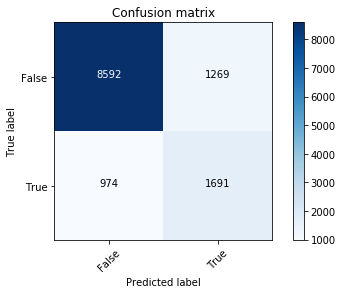

In [109]:
plot_confusion_matrix(cm, data.classes)

In [110]:
from sklearn.metrics import f1_score

In [111]:
f1_score(y, preds)  

0.6012444444444444

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[val_idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, val_idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(val_idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in val_idxs]
    title_probs = [probs[x] for x in val_idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect effusion")